# **Clustering lynx**

In [1]:
# Allow reloading of libraries without restarting the kernel
%load_ext autoreload
%autoreload 2

In [2]:
import random
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
from scipy.stats import norm
from safetensors import safe_open

import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from oml.functional.metrics import calc_cmc, calc_map, calc_precision
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import DataLoader
from torchvision import models
from tqdm import tqdm

from lynx_id.data.dataset import LynxDataset
from lynx_id.data.transformations_and_augmentations import transforms
from lynx_id.data.collate import collate_single
from lynx_id.model.embeddings import EmbeddingModel
from lynx_id.model.clustering import ClusteringModel
from lynx_id.eval.eval import EvalMetrics
from lynx_id.utils.plot_results import plot_multiple_bar

plt.rcParams['figure.figsize'] = [20, 5]

In [3]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"{DEVICE=}")

DEVICE='cuda'


In [4]:
random.seed(42)

## **Prepare data**

### Load datasets

In [5]:
train_lynxDataset = LynxDataset(
    dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_train.csv"), 
    loader="pil",
    transform=transforms,
    augmentation=None,
    probabilities=[1, 0, 0],
    mode='single',
    device="auto"
)

val_lynxDataset = LynxDataset(
    dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_val.csv"), 
    loader="pil",
    transform=transforms,
    augmentation=None,
    probabilities=[1, 0, 0],
    mode='single',
    device="auto"
)  # useful for computing the threshold for detecting new individuals when evaluating the test set

test_lynxDataset = LynxDataset(
    dataset_csv=Path("/gpfsscratch/rech/ads/commun/datasets/extracted/lynx_dataset_full_test.csv"), 
    loader="pil",
    transform=transforms,
    augmentation=None,
    probabilities=[1, 0, 0],
    mode='single',
    device="auto"
)

In [6]:
print(f"{len(train_lynxDataset)=} images")
print(f"{len(val_lynxDataset)=} images")
print(f"{len(test_lynxDataset)=} images")

len(train_lynxDataset)=8281 images
len(val_lynxDataset)=1774 images
len(test_lynxDataset)=1775 images


In [7]:
train_lynx_id_counts = train_lynxDataset.dataframe['lynx_id'].value_counts()
val_lynx_id_counts = val_lynxDataset.dataframe['lynx_id'].value_counts()
test_lynx_id_counts = test_lynxDataset.dataframe['lynx_id'].value_counts()


print(f"TRAIN | Number of individuals: {len(train_lynx_id_counts)}")
print(f"VAL   | Number of individuals: {len(val_lynx_id_counts)}")
print(f"TEST  | Number of individuals: {len(test_lynx_id_counts)}")

TRAIN | Number of individuals: 688
VAL   | Number of individuals: 410
TEST  | Number of individuals: 416


In [8]:
set_individuals_train = set(train_lynx_id_counts.index)
set_individuals_val = set(val_lynx_id_counts.index)
set_individuals_test = set(test_lynx_id_counts.index)

print(f"The train and val set share {len(set_individuals_train.intersection(set_individuals_val))} individuals in common.")
print(f"Compared to the training set, the val set has {len(set_individuals_val - set_individuals_train)} new individuals.\n")

print(f"The train and test set share {len(set_individuals_train.intersection(set_individuals_test))} individuals in common.")
print(f"Compared to the training set, the test set has {len(set_individuals_test - set_individuals_train)} new individuals.")

The train and val set share 380 individuals in common.
Compared to the training set, the val set has 30 new individuals.

The train and test set share 388 individuals in common.
Compared to the training set, the test set has 28 new individuals.


In [9]:
new_lynx_id_val = set_individuals_val - set_individuals_train
new_lynx_id_test = set_individuals_test - set_individuals_train

In [10]:
train_dataloader = DataLoader(
    train_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

val_dataloader = DataLoader(
    val_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

test_dataloader = DataLoader(
    test_lynxDataset,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_single
)

### Load our best model to get embeddings from image

In [14]:
embedding_model = EmbeddingModel(
    model_path="/gpfswork/rech/ads/commun/kg_tests/model_best_0.512.pth",
    device=DEVICE,
    base_resnet=False
)

In [ ]:
# Compute all embeddings
train_embeddings = embedding_model.compute_embeddings(
    train_dataloader
)

val_embeddings = embedding_model.compute_embeddings(
    val_dataloader
)

test_embeddings = embedding_model.compute_embeddings(
    test_dataloader
)

In [13]:
train_embeddings = train_embeddings.to("cpu")
val_embeddings = val_embeddings.to("cpu")
test_embeddings = test_embeddings.to("cpu")

print(f"TRAIN | Number of images: {train_embeddings.shape[0]} | Embedding shape: {train_embeddings.shape[1]}")
print(f"VAL   | Number of images: {val_embeddings.shape[0]}   | Embedding shape: {val_embeddings.shape[1]}")
print(f"TEST  | Number of images: {test_embeddings.shape[0]}  | Embedding shape: {test_embeddings.shape[1]}")

TRAIN | Number of images: 8281 | Embedding shape: 2048
VAL   | Number of images: 1774   | Embedding shape: 2048
TEST  | Number of images: 1775  | Embedding shape: 2048


In [24]:
val_lynx_id = val_lynxDataset.compute_new_lynx_id(train_lynxDataset)
test_lynx_id = test_lynxDataset.compute_new_lynx_id(train_lynxDataset)

100%|██████████| 1774/1774 [00:00<00:00, 3351664.55it/s]


count_new=31


100%|██████████| 1775/1775 [00:00<00:00, 3365682.46it/s]

count_new=35


In [25]:
# Check that we have new individuals
assert "New" in test_lynx_id
assert "New" in val_lynx_id

## **KNN**

In [16]:
clustering_model = ClusteringModel(
    embeddings_knowledge=train_embeddings,
    lynx_ids_knowledge=train_lynx_id,
    n_neighbors=5,
    algorithm="brute",
    metric="minkowski"
)

### Validation set

First, we cluster our validation set. This will allow us to evaluate its accuracy without detecting any new candidates.  
**Then, to detect new individuals, we'll test different thresholds to find the best one. This will be used to evaluate the test set.**

In [17]:
# Nearest Neighbors
val_candidates_nearest_neighbors = clustering_model.clustering(val_embeddings)

In [18]:
top_k = (1, 2, 3, 4, 5)

val_eval_metrics = EvalMetrics(
    candidates_nearest_neighbors=clustering_model.candidates_nearest_neighbors,
    lynx_id_true=val_lynx_id,
    top_k=top_k
)

In [19]:
accuracy_no_threshold = val_eval_metrics.compute_accuracy(lynx_id_predicted=clustering_model.one_knn())
print(f"Accuracy 1-KNN: {accuracy_no_threshold}")

Accuracy 1-KNN: 0.44701240135287484


In [20]:
threshold = val_eval_metrics.get_best_threshold(
    clustering_model=clustering_model,
    min_threshold=0.0,
    max_threshold=10.0,
    step=0.1
)
threshold

1.4000000000000001

We do a visual check and calculate the precision/recall for the New individual.

In [21]:
thresholds = [0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6, 1.8, 2.0]

score_threshold = {'precision': [], 'recall': [], 'accuracy': []}

for threshold in thresholds:
    candidates_predicted_new_individual = clustering_model.check_new_individual(
        candidates_predicted=clustering_model.one_knn(),
        threshold=threshold,
    )
    
    precision_recall = val_eval_metrics.precision_recall_individual(
        candidates_predicted=candidates_predicted_new_individual, 
        individual_name="New",
        verbose=False
    )

    accuracy_threshold = val_eval_metrics.compute_accuracy(
        lynx_id_predicted=candidates_predicted_new_individual,
    )
    
    score_threshold['precision'].append(precision_recall['precision'])
    score_threshold['recall'].append(precision_recall['recall'])
    score_threshold['accuracy'].append(accuracy_threshold)

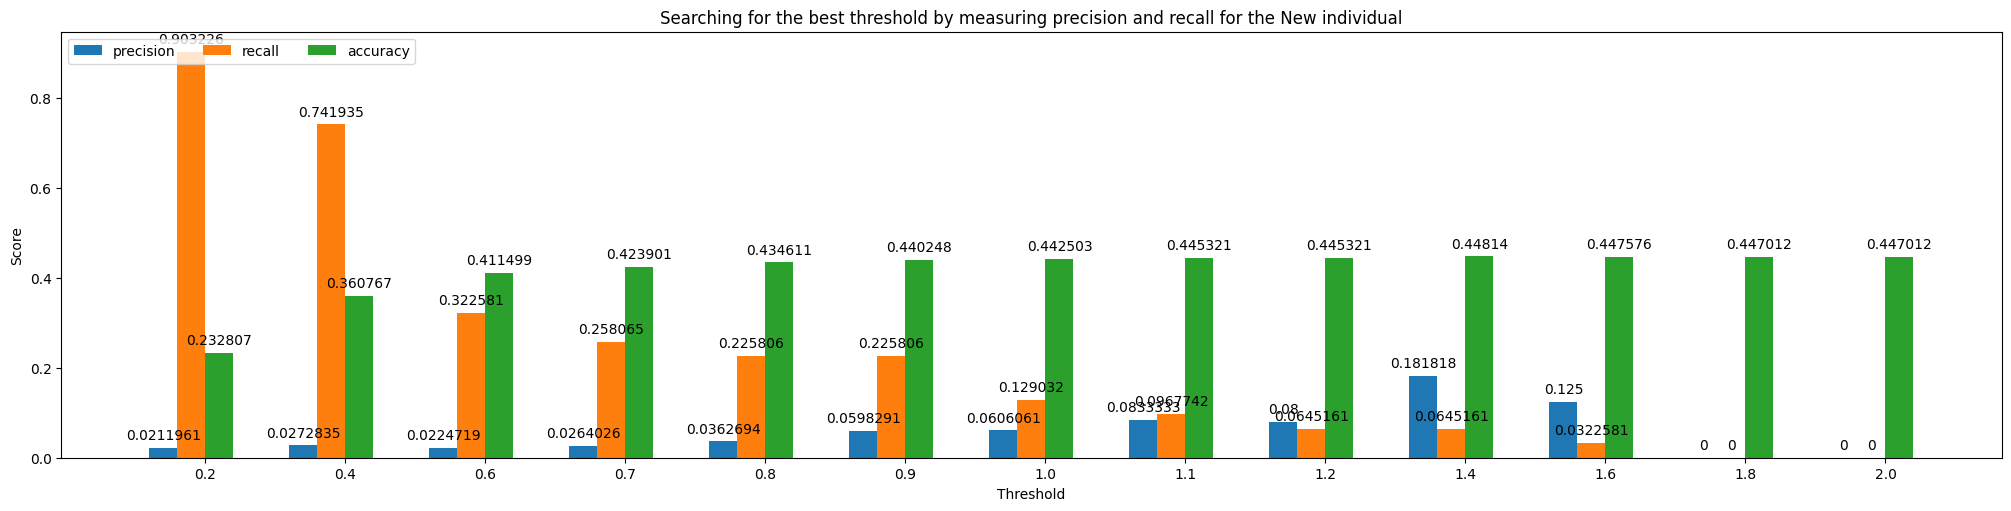

In [22]:
plot_multiple_bar(
    values=score_threshold,
    x_values=thresholds,
    xlabel="Threshold",
    ylabel="Score",
    title="Searching for the best threshold by measuring precision and recall for the New individual"
)

### Test set

#### CMC@k, mAP@k
We use the `open-metric-learning` module, which offers ready-made implementations of **CMC@k** and **mAP@k**.

Before calculating the metrics, we need to **adapt `candidates_nearest_neighbors` to the detection of new individuals after our calculation with confidence intervals**. Candidate i, if detected as new, will have "New" as its nearest neighbour, then its neighbours calculated via KNN will be shifted by 1. The last one is therefore forgotten.  

Example:  
candidate i: `["A", "B", "C", "D"]` detected as New -> `["New", "A", "B", "C", "D"]`

In [23]:
top_k = (1, 2, 3, 4, 5)

clustering_model.clustering(test_embeddings)

test_eval_metrics = EvalMetrics(
    candidates_nearest_neighbors=clustering_model.candidates_nearest_neighbors,
    lynx_id_true=test_lynx_id,
    top_k=top_k
)

Computation of accuracy without detection of new candidates with 1-KNN.

In [24]:
accuracy_no_threshold = test_eval_metrics.compute_accuracy(lynx_id_predicted=clustering_model.one_knn())
print(f"Accuracy 1-KNN: {accuracy_no_threshold}")

Accuracy 1-KNN: 0.46816901408450706


#### Ideal threshold

We won't be using it to evaluate our test set. We'll use the one obtained from the validation set.

In [25]:
theorical_best_threshold = test_eval_metrics.get_best_threshold(
    clustering_model=clustering_model,
    min_threshold=0.0,
    max_threshold=10.0,
    step=0.1
)
theorical_best_threshold

0.9

In [26]:
thresholds = [0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.4, 1.6, 1.8, 2.0]

score_threshold = {'precision': [], 'recall': [], 'accuracy': []}

for threshold in thresholds:
    candidates_predicted_new_individual = clustering_model.check_new_individual(
        candidates_predicted=clustering_model.one_knn(),
        threshold=threshold,
    )
    
    precision_recall = test_eval_metrics.precision_recall_individual(
        candidates_predicted=candidates_predicted_new_individual, 
        individual_name="New",
        verbose=False
    )

    accuracy_threshold = test_eval_metrics.compute_accuracy(
        lynx_id_predicted=candidates_predicted_new_individual,
    )
    
    score_threshold['precision'].append(precision_recall['precision'])
    score_threshold['recall'].append(precision_recall['recall'])
    score_threshold['accuracy'].append(accuracy_threshold)

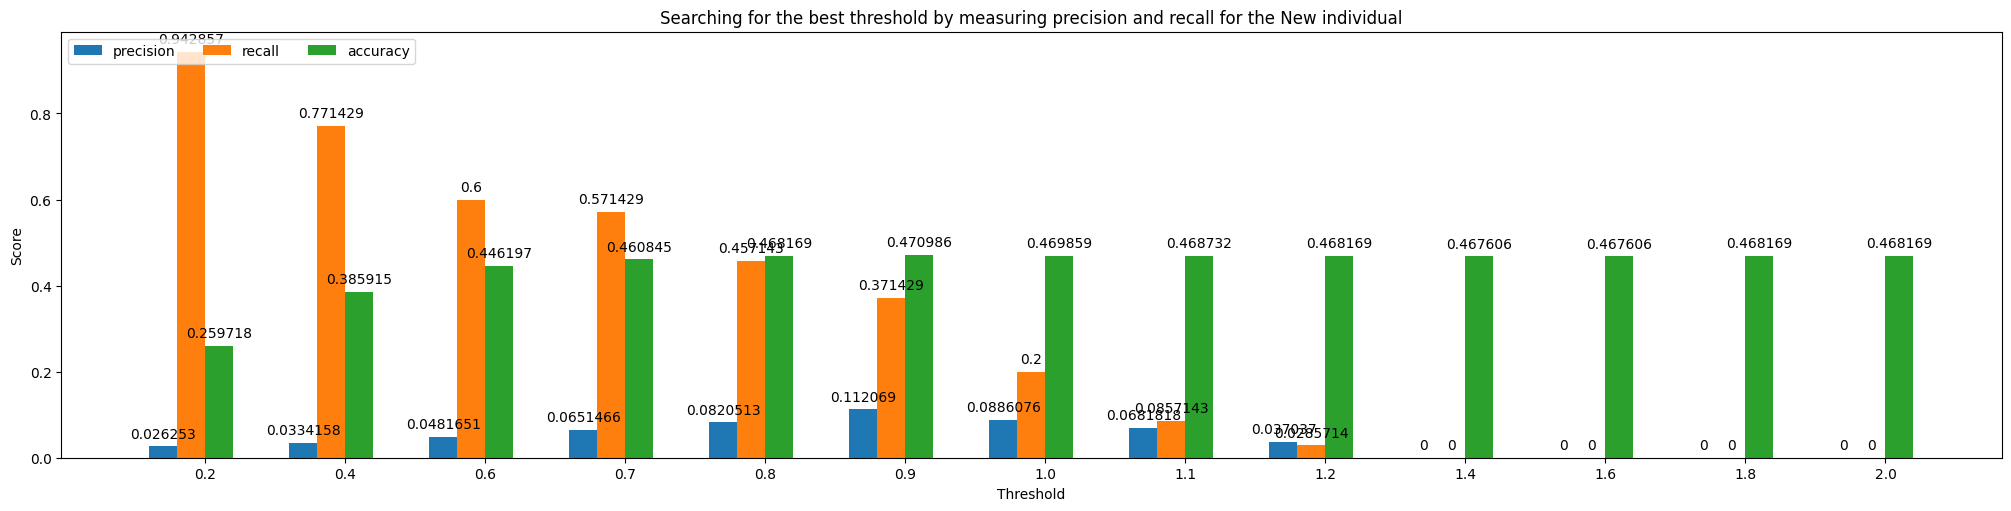

In [27]:
plot_multiple_bar(
    values=score_threshold,
    x_values=thresholds,
    xlabel="Threshold",
    ylabel="Score",
    title="Searching for the best threshold by measuring precision and recall for the New individual"
)

#### Metric computation

In [28]:
cmc_values = {}
map_values = {}

In [29]:
### Threshold ###
print("-"*50, "New individual based on threshold", "-"*50)
candidates_predicted_new_individual = clustering_model.check_new_individual(
    embeddings=test_embeddings,
    candidates_predicted=clustering_model.one_knn(),
    threshold=threshold,
)

precision_recall = test_eval_metrics.precision_recall_individual(
    candidates_predicted=candidates_predicted_new_individual, 
    individual_name="New",
    verbose=True
)
print(precision_recall)

accuracy_threshold = test_eval_metrics.compute_accuracy(
    lynx_id_predicted=candidates_predicted_new_individual,
)
print(f"Accuracy 1-KNN threshold: {accuracy_threshold}")


# CMC@k + mAP@k
candidates_nearest_neighbors_new = clustering_model.compute_candidates_nearest_neighbors_new(
    candidates_predicted_new_individual=candidates_predicted_new_individual
)
test_eval_metrics.candidates_nearest_neighbors = candidates_nearest_neighbors_new
cmc_k_mean, map_k_mean = test_eval_metrics.compute_cmc_map_metrics()
print(f"{cmc_k_mean=}")
print(f"{map_k_mean=}")
cmc_values['threshold'] = list(cmc_k_mean.values())
map_values['threshold'] = list(map_k_mean.values())

-------------------------------------------------- New individual based on threshold --------------------------------------------------
New individual predicted 0 times (total number of images: 1775). In reality, the New individual appears 35 times.
{'precision': 0, 'recall': 0.0}
Accuracy 1-KNN threshold: 0.46816901408450706
cmc_k_mean={1: 0.468, 2: 0.53, 3: 0.562, 4: 0.584, 5: 0.602}
map_k_mean={1: 0.468, 2: 0.499, 3: 0.508, 4: 0.51, 5: 0.51}


#### Detection of new candidates using the Gaussian method

Based on the Gaussian distribution of the clusters in the train.

In [30]:
### Gaussian ###
print("\n", "-"*50, "New individual based on gaussian", "-"*50)

accuracy_list = []
n_neighbors=5
confidence_levels = [0.68, 0.95, 0.997]

for confidence in confidence_levels:
    print("*"*50, confidence, "*"*50)
    results = []
    for k, prediction in {"1_knn": clustering_model.one_knn(), f"{n_neighbors}_knn": clustering_model.n_knn()}.items():
        clustering_model.clustering(test_embeddings)
        candidates_predicted_new_individual = clustering_model.check_new_individual(
            embeddings=test_embeddings,
            candidates_predicted=prediction,
            success_percentage_threshold=80,
            confidence=confidence
        )
        
        accuracy = test_eval_metrics.compute_accuracy(
            lynx_id_predicted=candidates_predicted_new_individual,
        )
        print(f"Accuracy {k}: {accuracy}")
        results.append(accuracy)
        
        candidates_nearest_neighbors_new = clustering_model.compute_candidates_nearest_neighbors_new(
            candidates_predicted_new_individual=candidates_predicted_new_individual
        )
        test_eval_metrics.candidates_nearest_neighbors = candidates_nearest_neighbors_new
    
        # CMC@k + mAP@k
        cmc_k_mean, map_k_mean = test_eval_metrics.compute_cmc_map_metrics()
        print(f"{cmc_k_mean=}")
        print(f"{map_k_mean=}")
        
        if k == "1_knn":
            cmc_values[confidence] = list(cmc_k_mean.values())
            map_values[confidence] = list(map_k_mean.values())

    
    accuracy_list.append(results)


 -------------------------------------------------- New individual based on gaussian --------------------------------------------------
************************************************** 0.68 **************************************************


  0%|          | 0/688 [00:00<?, ?it/s]/gpfsdswork/projects/rech/ads/uxp55sd/DP-SCR_Identify-and-estimate-density-lynx-population/lynx_id/model/clustering.py:118: UserWarning: var(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /gpfs7kro/gpfslocalsup/src/pub/anaconda-py3/2023.09/pytorch-gpu-2.2.0+py3.11.7+cuda-12.2/pytorch-2.2.0/aten/src/ATen/native/ReduceOps.cpp:1760.)
  self.cluster_variances[lynx] = torch.var(self.embeddings_knowledge[lynx_idx], dim=0).tolist()
compute_confidence_intervals:   0%|          | 0/688 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infra

Accuracy 1_knn: 0.22985915492957745
cmc_k_mean={1: 0.23, 2: 0.503, 3: 0.556, 4: 0.587, 5: 0.603}
map_k_mean={1: 0.23, 2: 0.366, 3: 0.395, 4: 0.408, 5: 0.414}


compute_confidence_intervals:   0%|          | 0/688 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 688/688 [00:01<00:00, 656.46it/s]


Accuracy 5_knn: 0.22028169014084506
cmc_k_mean={1: 0.234, 2: 0.507, 3: 0.554, 4: 0.587, 5: 0.604}
map_k_mean={1: 0.234, 2: 0.37, 3: 0.397, 4: 0.411, 5: 0.416}
************************************************** 0.95 **************************************************


compute_confidence_intervals:   0%|          | 0/688 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 688/688 [00:01<00:00, 600.67it/s]


Accuracy 1_knn: 0.4422535211267606
cmc_k_mean={1: 0.442, 2: 0.525, 3: 0.561, 4: 0.584, 5: 0.602}
map_k_mean={1: 0.442, 2: 0.484, 3: 0.495, 4: 0.499, 5: 0.498}


compute_confidence_intervals:   0%|          | 0/688 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 688/688 [00:01<00:00, 604.39it/s]


Accuracy 5_knn: 0.4067605633802817
cmc_k_mean={1: 0.441, 2: 0.53, 3: 0.562, 4: 0.585, 5: 0.604}
map_k_mean={1: 0.441, 2: 0.485, 3: 0.496, 4: 0.499, 5: 0.499}
************************************************** 0.997 **************************************************


compute_confidence_intervals:   0%|          | 0/688 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 688/688 [00:01<00:00, 607.22it/s]


Accuracy 1_knn: 0.4597183098591549
cmc_k_mean={1: 0.46, 2: 0.528, 3: 0.562, 4: 0.584, 5: 0.602}
map_k_mean={1: 0.46, 2: 0.494, 3: 0.504, 4: 0.506, 5: 0.506}


compute_confidence_intervals:   0%|          | 0/688 [00:00<?, ?it/s]/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2244: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/gpfslocalsup/pub/anaconda-py3/2023.09/envs/pytorch-gpu-2.2.0+py3.11.7/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2245: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc
compute_confidence_intervals: 100%|██████████| 688/688 [00:01<00:00, 529.09it/s]


Accuracy 5_knn: 0.4191549295774648
cmc_k_mean={1: 0.459, 2: 0.53, 3: 0.562, 4: 0.584, 5: 0.603}
map_k_mean={1: 0.459, 2: 0.494, 3: 0.504, 4: 0.506, 5: 0.506}


### Plot results

#### CMC@k

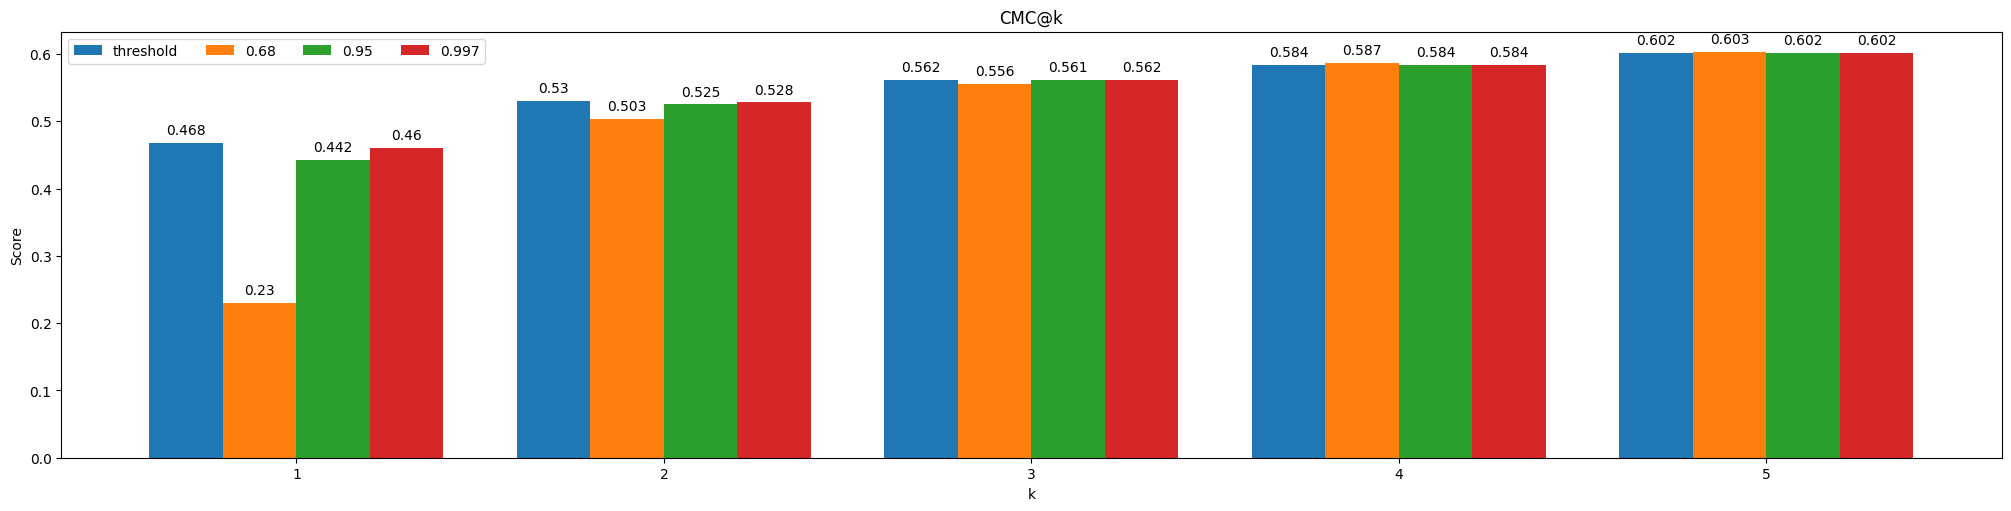

In [31]:
# CMC@k
plot_multiple_bar(
    values=cmc_values,
    x_values=top_k,
    xlabel='k',
    ylabel='Score',
    title='CMC@k'
)

#### mAP@k

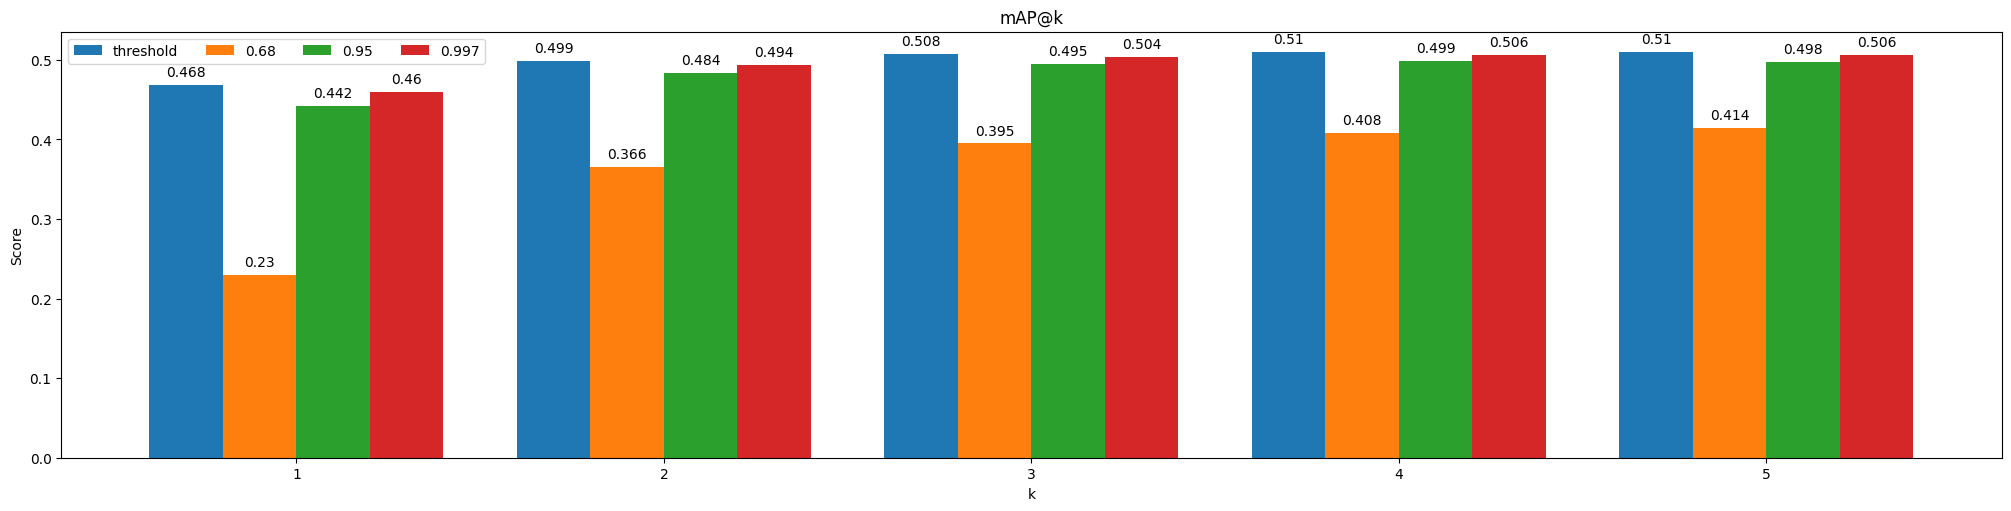

In [32]:
# mAP@k
plot_multiple_bar(
    values=map_values,
    x_values=top_k,
    xlabel='k',
    ylabel='Score',
    title='mAP@k'
)

#### Accuracy

To compare the candidate's choice between 1-knn and n-knn. If n-knn, the lynx_id of the current image will be the one found most often among the neighbours.

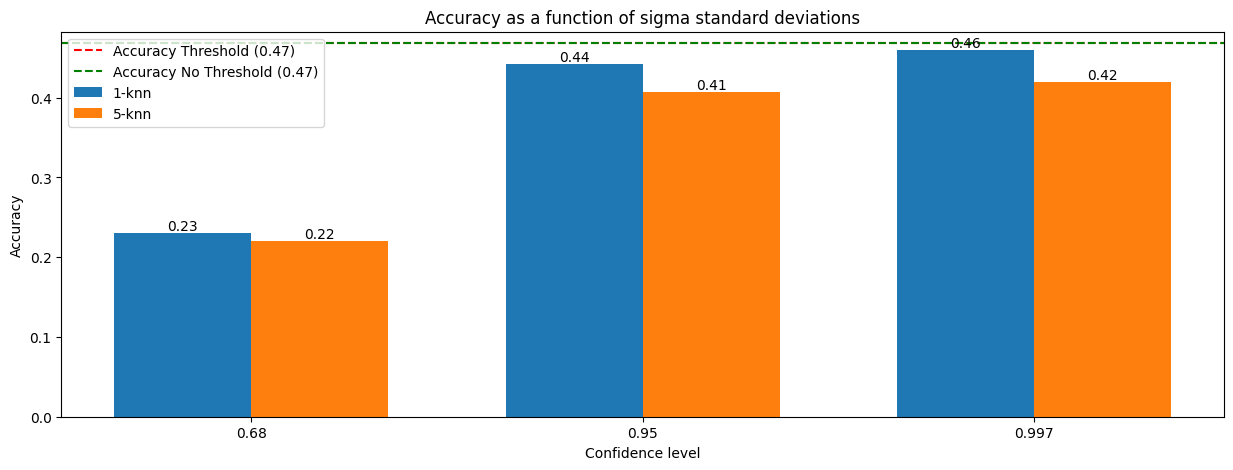

In [33]:
# Accuracy plot
accuracy_list_t = list(zip(*accuracy_list))

plt.rcParams["figure.figsize"] = (15,5)
fig, ax = plt.subplots()

width = 0.35

# Gaussian
bar1 = ax.bar(range(len(accuracy_list)), accuracy_list_t[0], width=width, label='1-knn')
bar2 = ax.bar([x + width for x in range(len(accuracy_list))], accuracy_list_t[1], width=width, label=f'{n_neighbors}-knn')

# Classic threshold
ax.axhline(y=accuracy_threshold, color='r', linestyle='--', label=f'Accuracy Threshold ({accuracy_threshold:.2f})')
ax.legend()

# No threshold
ax.axhline(y=accuracy_no_threshold, color='g', linestyle='--', label=f'Accuracy No Threshold ({accuracy_no_threshold:.2f})')
ax.legend()

ax.legend()

ax.set_xticks([x + width / 2 for x in range(len(accuracy_list))])
ax.set_xticklabels(confidence_levels)
ax.set_xlabel('Confidence level')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy as a function of sigma standard deviations')

ax.legend()

def add_text_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_text_labels(bar1)
add_text_labels(bar2)

plt.show()